## Raw pupil data preprocessing

### Reference

Major referenced papers:
1. Total VREcall, https://dl-acm-org.libproxy1.nus.edu.sg/doi/10.1145/3534615 
2. GazeR: A Package for Processing Gaze Position and Pupil Size Data. https://pubmed.ncbi.nlm.nih.gov/32291732/ 
3. ComputationalMR. https://github.com/eth-ait/ComputationalMR 
4. Preprocessing pupil data: guidelines and code. https://link.springer.com/content/pdf/10.3758/s13428-018-1075-y.pdf Github repository https://github.com/ElioS-S/pupil-size. Check this when have time, seems no need to integrate it now because it is too complicated but won't improve my LHIPA score much.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from numba import jit
import math, os

def plotter(ax, data1, data2, param_dict):
    out = ax.plot(data1, data2, **param_dict)
    return out

### Read raw data

In [2]:
read_file_path = '../Data/RawData/05-09-19-33-lowlux-ONEBACK/left2D_84Hz.csv'
SAMPLING_RATE = int((read_file_path.split('_')[-1]).split('Hz')[0])
data = pd.read_csv(read_file_path)

In [3]:
df = data[['Timestamp','Confidence','Diameter','Event']].copy()
df

,Timestamp,Confidence,Diameter,Event
0,189116.991585,0.763565,30.454937,default
1,189117.004188,0.641401,29.660538,default
2,189117.014741,0.699318,29.736210,default
3,189117.027958,0.764185,29.560902,default
4,189117.034180,0.679118,29.214853,default
...,...,...,...,...
11021,189248.092300,0.587221,30.041607,sitting
11022,189248.100471,0.510293,29.183565,sitting
11023,189248.112247,0.560398,27.330959,sitting
11024,189248.122233,0.837478,27.889095,sitting


### De-blinking and remove data with low confidence

#### Extending blinks

In [4]:
## Check how David Linderbaure's group deal with the blinks. Use confidence to identify blinks. They removed the data within 200ms. However, they did not interpolate the eliminated ones.
## Here I clean data before and after 200ms of blinks. The input is the numpy data list of the "confidence" conlumn. Then return a list that marks which indecies are blinks. 
def mark_blinks(data):
    # Variables initialization:
    blinks = []
    
    min_num_blinks = 2
    num_samples = len(data)
    i = 0
    min_conf = 0.25
    
    duration_sample_remove_ms = 200
    num_samples_removed = int(math.ceil(SAMPLING_RATE / (1000 / duration_sample_remove_ms)))
    
    # Find blinks, identified by low confidence data.##TODO: get the data into a class.
    while i < num_samples:
        if data[i] < min_conf and i < num_samples - 1:
            runner = 1
            next_data = data[i + runner]
            while next_data < min_conf:
                runner = runner + 1
                if i + runner >= num_samples:
                    break
                next_data = data[i + runner]
            
            if runner >= min_num_blinks:
                blinks.append((i, runner))
                
            i = i + runner  # This blink is over, update to the next.
        else:
            i = i + 1
    
    # Mark data before and after 200ms of blinks.
    blink_markers = np.ones(num_samples)
    for i in range(len(blinks)):
        blink_index = blinks[i][0]
        blink_length = blinks[i][1]
        
        for j in range(0, blink_length):
            blink_markers[blink_index + j] = 0
        
        for j in range(0, num_samples_removed):
            decrement_index = blink_index - j
            increment_index = blink_index + blink_length + j
            
            # Check the boundary conditions.
            if decrement_index >=0:
                blink_markers[decrement_index] = 0
            
            if increment_index < num_samples:
                blink_markers[increment_index] = 0
    
    return blink_markers

In [5]:
## Get confidence column.
data_conf = df['Confidence'].copy()
data_conf

0        0.763565
1        0.641401
2        0.699318
3        0.764185
4        0.679118
           ...   
11021    0.587221
11022    0.510293
11023    0.560398
11024    0.837478
11025    0.861766
Name: Confidence, Length: 11026, dtype: float64

In [6]:
blink_markers = mark_blinks(data=data_conf)
blink_markers

array([1., 1., 1., ..., 1., 1., 1.])

In [7]:
## Count the number of data that marked as blinks.
print(len(blink_markers[np.where(blink_markers==0)]))

487


In [8]:
## Add this column into the dataframe.
df['Blink_marks'] = blink_markers
df

,Timestamp,Confidence,Diameter,Event,Blink_marks
0,189116.991585,0.763565,30.454937,default,1.0
1,189117.004188,0.641401,29.660538,default,1.0
2,189117.014741,0.699318,29.736210,default,1.0
3,189117.027958,0.764185,29.560902,default,1.0
4,189117.034180,0.679118,29.214853,default,1.0
...,...,...,...,...,...
11021,189248.092300,0.587221,30.041607,sitting,1.0
11022,189248.100471,0.510293,29.183565,sitting,1.0
11023,189248.112247,0.560398,27.330959,sitting,1.0
11024,189248.122233,0.837478,27.889095,sitting,1.0


In [9]:
## Remove the blinks.
df_no_blinks = df.copy()
df_no_blinks['Dia_Deblinked'] = df_no_blinks['Diameter'].copy()
df_no_blinks.loc[(df_no_blinks.Blink_marks == 0),'Dia_Deblinked'] = np.nan
print(df_no_blinks['Dia_Deblinked'].isna().sum())

## Remove data with low confidence.
threshold_low_conf = 0.6
df_no_low_conf = df_no_blinks.copy()
df_no_low_conf.loc[(df_no_low_conf.Blink_marks <= threshold_low_conf),'Dia_Deblinked'] = np.nan
print(df_no_low_conf['Dia_Deblinked'].isna().sum())

487
487


<AxesSubplot:>

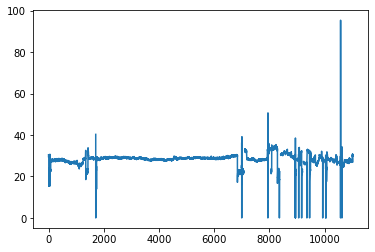

In [10]:
df_de_blinks = df_no_low_conf.copy()
df_de_blinks.Dia_Deblinked.plot()

#### Smoothing

<AxesSubplot:>

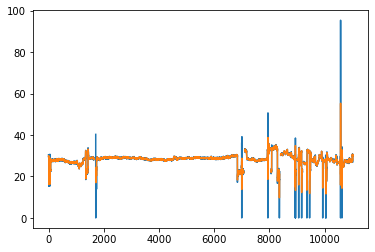

In [11]:
## Smoothing via Moving average or Hanning window.
# Hanning window moving average.
df_hann = df_de_blinks.copy()
df_hann['Dia_Hann'] = df_hann['Dia_Deblinked'].rolling(window=5, center=True, win_type='hann').mean()

# Plot.
df_hann.Dia_Deblinked.plot()
df_hann.Dia_Hann.plot()

<AxesSubplot:>

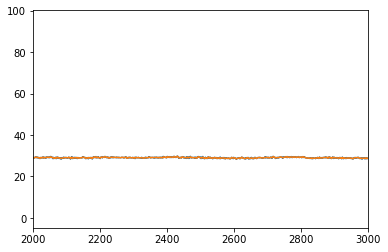

In [12]:
## Check one data portion.
df_hann.Dia_Deblinked.plot(xlim=(2000,3000))
df_hann.Dia_Hann.plot()

#### Interpolation

In [13]:
## Interpolation (linear and spline)
df_interpolate = df_hann.copy()
df_interpolate['Dia_Spline3'] = df_interpolate['Dia_Hann'].interpolate(method='spline',order=3)
df_interpolate['Dia_Linear'] = df_interpolate['Dia_Hann'].interpolate(method='linear') # piecewise and linear look almost the same
df_interpolate['Dia_Cubic'] = df_interpolate['Dia_Hann'].interpolate(method='cubic')
df_interpolate['Dia_PiecewisePoly'] = df_interpolate['Dia_Hann'].interpolate(method='piecewise_polynomial')

<AxesSubplot:>

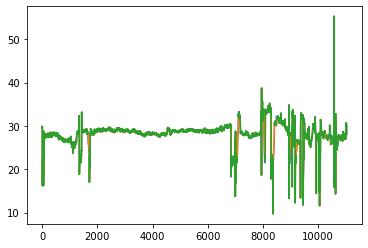

In [14]:
# Plot and see the curves.
# Initialize boundaries.
# xlim_low = 0
# xlim_high = 3000
# ylim_low = 10
# ylim_high = 35

# df_interpolate.Dia_Spline3.plot(xlim=(xlim_low,xlim_high),ylim=(ylim_low,ylim_high))
df_interpolate.Dia_Spline3.plot() # Feels this interpolation tactic is better.
df_interpolate.Dia_Linear.plot()
df_interpolate.Dia_Hann.plot()
# df_interpolate.Dia_Cubic.plot()
# df_interpolate.Dia_PiecewisePoly.plot()  # This seems good as well. Transitions are smooth and natural.

### Artifact rejection

In [15]:
## This part is directly cited from Sam's work.

# Filtering outliers 
# Lan et al. 2020 - median filter with sliding window of 10s
# Testing with numba optimised for-loop implementation of a Hampel Filter
# Note to self: I think this filter is also commonly used for pupil diameter filtering

@jit(nopython=True)
def hampel_filter_forloop_numba(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [16]:
df_outlier_reject = df_interpolate.copy()

x_SP3, outlier_x_SP3 = hampel_filter_forloop_numba(df_outlier_reject.Dia_Spline3.to_numpy(), 10) #applying hampel filter with win size 10
x_L, outlier_x_L = hampel_filter_forloop_numba(df_outlier_reject.Dia_Linear.to_numpy(), 10)
df_outlier_reject['Dia_Spline3_Ham'] = x_SP3.tolist()
df_outlier_reject['Dia_Linear_Ham'] = x_L.tolist()

<AxesSubplot:>

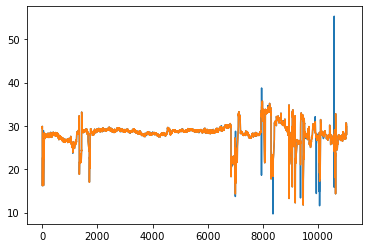

In [17]:
# Test spline curve.
df_outlier_reject.Dia_Spline3.plot()
df_outlier_reject.Dia_Spline3_Ham.plot()

<AxesSubplot:>

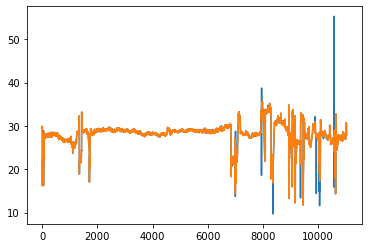

In [18]:
# Test linear curve.
df_outlier_reject.Dia_Linear.plot()
df_outlier_reject.Dia_Linear_Ham.plot()

### Baseline correction (subtractive)

In [19]:
df_baseline_corr = df_outlier_reject.copy()
df_baseline = df_baseline_corr[(df_outlier_reject.Event == 'default')]
df_baseline

,Timestamp,Confidence,Diameter,Event,Blink_marks,Dia_Deblinked,Dia_Hann,Dia_Spline3,Dia_Linear,Dia_Cubic,Dia_PiecewisePoly,Dia_Spline3_Ham,Dia_Linear_Ham
0,189116.991585,0.763565,30.454937,default,1.0,30.454937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,189117.004188,0.641401,29.660538,default,1.0,29.660538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,189117.014741,0.699318,29.736210,default,1.0,29.736210,29.673465,29.673465,29.673465,29.673465,29.673465,29.673465,29.673465
3,189117.027958,0.764185,29.560902,default,1.0,29.560902,29.518217,29.518217,29.518217,29.518217,29.518217,29.518217,29.518217
4,189117.034180,0.679118,29.214853,default,1.0,29.214853,29.414522,29.414522,29.414522,29.414522,29.414522,29.414522,29.414522
...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,189127.819681,0.827260,27.331142,default,1.0,27.331142,27.126483,27.126483,27.126483,27.126483,27.126483,26.697556,26.697556
967,189127.829376,0.842954,26.906649,default,1.0,26.906649,26.934853,26.934853,26.934853,26.934853,26.934853,26.934853,26.934853
968,189127.843751,0.847066,26.594973,default,1.0,26.594973,26.701920,26.701920,26.701920,26.701920,26.701920,26.701920,26.701920
969,189127.854721,0.875442,26.711086,default,1.0,26.711086,26.693192,26.693192,26.693192,26.693192,26.693192,26.693192,26.693192


In [20]:
base_median = df_baseline.Dia_Spline3_Ham.median()
df_baseline_corr['Dia_Spline3_Base'] = df_baseline_corr['Dia_Spline3_Ham'] - base_median
# df_baseline_corr['Dia_Spline3_Base'] = df_baseline_corr['Dia_Spline3_Ham'] / base_median
df_baseline_corr

,Timestamp,Confidence,Diameter,Event,Blink_marks,Dia_Deblinked,Dia_Hann,Dia_Spline3,Dia_Linear,Dia_Cubic,Dia_PiecewisePoly,Dia_Spline3_Ham,Dia_Linear_Ham,Dia_Spline3_Base
0,189116.991585,0.763565,30.454937,default,1.0,30.454937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,189117.004188,0.641401,29.660538,default,1.0,29.660538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,189117.014741,0.699318,29.736210,default,1.0,29.736210,29.673465,29.673465,29.673465,29.673465,29.673465,29.673465,29.673465,2.164235
3,189117.027958,0.764185,29.560902,default,1.0,29.560902,29.518217,29.518217,29.518217,29.518217,29.518217,29.518217,29.518217,2.008987
4,189117.034180,0.679118,29.214853,default,1.0,29.214853,29.414522,29.414522,29.414522,29.414522,29.414522,29.414522,29.414522,1.905293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11021,189248.092300,0.587221,30.041607,sitting,1.0,30.041607,29.866894,29.866894,29.866894,29.866894,29.866894,29.866894,29.866894,2.357665
11022,189248.100471,0.510293,29.183565,sitting,1.0,29.183565,28.934924,28.934924,28.934924,28.934924,28.934924,28.934924,28.934924,1.425694
11023,189248.112247,0.560398,27.330959,sitting,1.0,27.330959,27.933645,27.933645,27.933645,27.933645,27.933645,27.933645,27.933645,0.424415
11024,189248.122233,0.837478,27.889095,sitting,1.0,27.889095,NaN,29.802692,27.933645,NaN,NaN,29.802692,27.933645,2.293462


<AxesSubplot:>

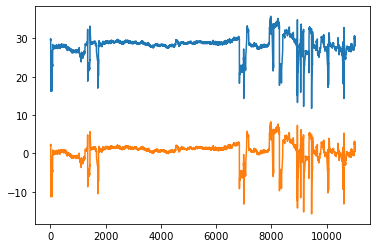

In [21]:
# Test with plots.
df_baseline_corr.Dia_Spline3_Ham.plot()
df_baseline_corr.Dia_Spline3_Base.plot()

In [22]:
# Split data according to different events. Return one-d arrays that could be directly processed later.
diameter_default = df_baseline_corr[(df_baseline_corr.Event == 'default')].Dia_Spline3_Base
diameter_sitting = df_baseline_corr[(df_baseline_corr.Event == 'sitting')].Dia_Spline3_Base
diameter_reading_sitting = df_baseline_corr[(df_baseline_corr.Event == 'reading-sitting')].Dia_Spline3_Base

### Export data to csv for processing

In [23]:
df_export = df_baseline_corr[['Dia_Spline3_Base', 'Event']].copy()
# Get rid of the nan values.
df_export = df_export.dropna()
df_export

,Dia_Spline3_Base,Event
2,2.164235,default
3,2.008987,default
4,1.905293,default
5,2.127888,default
6,2.311654,default
...,...,...
11021,2.357665,sitting
11022,1.425694,sitting
11023,0.424415,sitting
11024,2.293462,sitting


In [24]:
# Export data.
file_name = read_file_path.split('/')[-2:]

folder_path = '../Data/PreprocessedData/' + file_name[0] + '/'
if os.path.exists(folder_path) is False:
    os.makedirs(folder_path)

write_file_path = folder_path + file_name[1]
df_export.to_csv(write_file_path)

In [25]:
# Store the file name to be used in computing file.
%store write_file_path

# Store the sampling rate to be used in the computing file.
%store SAMPLING_RATE

Stored 'write_file_path' (str)
Stored 'SAMPLING_RATE' (int)


In [26]:
# Run the algorithm from the specific file.
%run ./PreprocessedPupilDataIPAComputing.ipynb
lhipa  # Directly access to the target data.

Data read from: ../Data/PreprocessedData/05-09-19-33-lowlux-ONEBACK/left2D_84Hz.csv


1.7222

In [27]:
# import papermill as pm

# pm.execute_notebook(
#    './PreprocessedPupilDataIPAComputing.ipynb',
#    './Results.ipynb'
# )